In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
df = pd.read_csv("resultats_tests_comparaison.csv")

# Nettoyage : conversion des colonnes nécessaires
df['temps_calcul'] = pd.to_numeric(df['temps_calcul'], errors='coerce')
df['temps_iteration'] = pd.to_numeric(df['temps_iteration'], errors='coerce')


In [ ]:
# Calcul des accélérations à partir des cas où nombre_de_processus == 1
df['accel_global'] = 0.0
df['accel_temp'] = 0.0

# Pour chaque combinaison unique de (longueur, discretisation, vent, start)
group_keys = ['longueur', 'discretisation', 'vent', 'start']
grouped = df.groupby(group_keys)

# Calcul des accélérations
for keys, group in grouped:
    ref = group[group['nombre_de_processus'] == 1]
    if not ref.empty:
        t_ref_total = ref['temps_iteration'].values[0]
        t_ref_calc = ref['temps_calcul'].values[0]

        mask = (df['longueur'] == keys[0]) & \
               (df['discretisation'] == keys[1]) & \
               (df['vent'] == keys[2]) & \
               (df['start'] == keys[3])

        df.loc[mask, 'accel_global'] = t_ref_total / df.loc[mask, 'temps_iteration']
        df.loc[mask, 'accel_temp'] = t_ref_calc / df.loc[mask, 'temps_calcul']

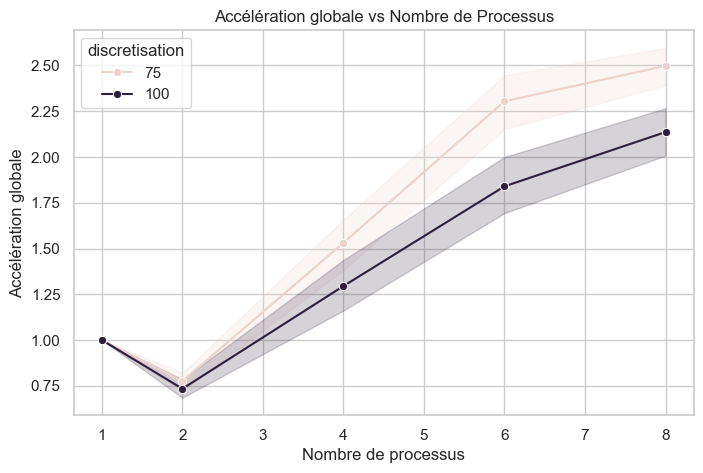

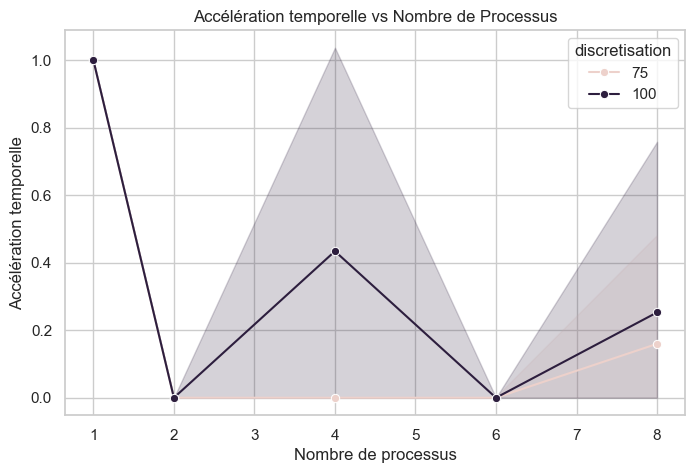

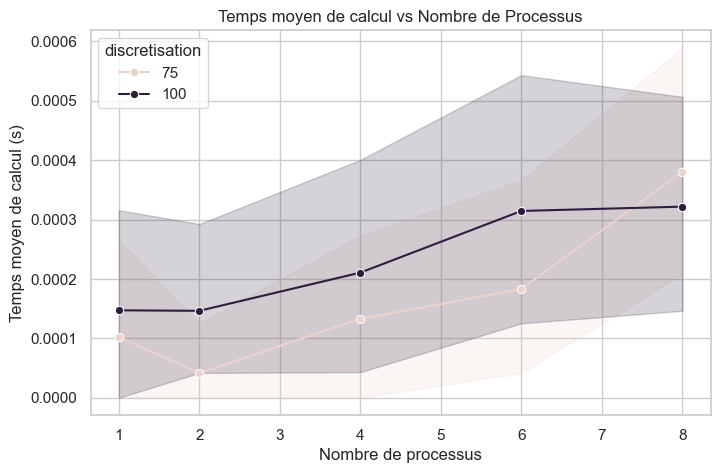

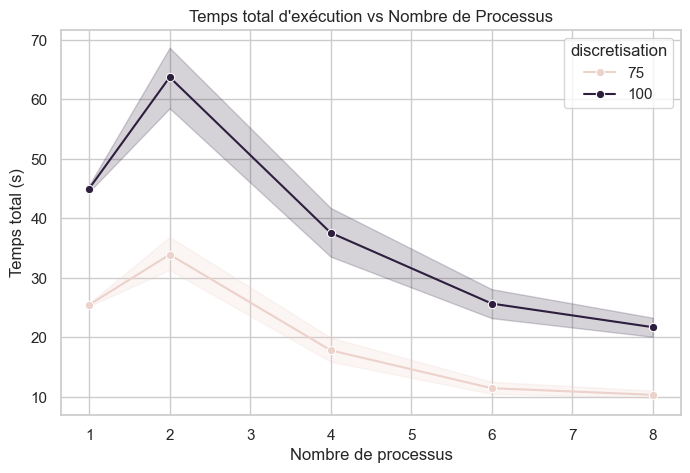

Résultats enregistrés dans resultats_analyses.csv


In [15]:
# Génération des graphes
sns.set(style="whitegrid")

def plot_graph(x, y, title, ylabel, filename):
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df, x=x, y=y, hue='discretisation', marker='o')
    plt.title(title)
    plt.xlabel("Nombre de processus")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Accélération globale
plot_graph("nombre_de_processus", "accel_global", "Accélération globale vs Nombre de Processus", "Accélération globale", "accel_global.png")

# Accélération temporelle
plot_graph("nombre_de_processus", "accel_temp", "Accélération temporelle vs Nombre de Processus", "Accélération temporelle", "accel_temp.png")

# Temps moyen de calcul
plot_graph("nombre_de_processus", "temps_calcul", "Temps moyen de calcul vs Nombre de Processus", "Temps moyen de calcul (s)", "temps_moyen_calcul.png")

# Temps total d'exécution
plot_graph("nombre_de_processus", "temps_iteration", "Temps total d'exécution vs Nombre de Processus", "Temps total (s)", "temps_total_execution.png")

# Sauvegarde des résultats
output_file = "resultats_analyses.csv"
df.to_csv(output_file, index=False)
print(f"Résultats enregistrés dans {output_file}")


In [ ]:
# Convertir les colonnes 'vent' et 'start' en tuples pour une comparaison correcte
df['vent'] = df['vent'].apply(lambda x: tuple(map(int, x.strip("()").split(",")))
df['start'] = df['start'].apply(lambda x: tuple(map(int, x.strip("()").split(",")))

# Filtrer pour le cas séquentiel (processus = 1)
df_seq = df[df["nombre_de_processus"] == 1]

# Calculer les temps moyens pour le cas séquentiel (en ignorant les zéros non significatifs)
temps_calcul_moyen = df_seq["temps_calcul"].replace(0, np.nan).mean(skipna=True)
temps_affichage_moyen = df_seq["temps_affichage"].replace(0, np.nan).mean(skipna=True)
temps_total_iteration_moyen = df_seq["temps_iteration"].mean()
temps_total_simulation = df_seq.groupby(["longueur", "discretisation", "vent", "start"])["temps_iteration"].sum().mean()

# Créer le tableau LaTeX avec gestion des valeurs manquantes
latex_table = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Temps moyen observé en mode séquentiel}}
\\begin{{tabular}}{{@{{}}cccc@{{}}}}
\\toprule
\\textbf{{Temps de calcul (s)}} & \\textbf{{Temps d'affichage (s)}} & \\textbf{{Total / itération (s)}} & \\textbf{{Total (s)}} \\\\
\\midrule
{temps_calcul_moyen:.5f} & {temps_affichage_moyen:.5f} & {temps_total_iteration_moyen:.5f} & {temps_total_simulation:.5f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""

# Filtrer une configuration spécifique (corrigée pour correspondre aux données)
example_params = {
    "longueur": 1,
    "discretisation": 100,
    "vent": (2, 3),  # Tuple au lieu de chaîne
    "start": (50, 50)
}

# Filtrage avec conversion des tuples
filtered = df[
    (df["longueur"] == example_params["longueur"]) &
    (df["discretisation"] == example_params["discretisation"]) &
    (df["vent"].apply(lambda x: x == example_params["vent"])) &
    (df["start"].apply(lambda x: x == example_params["start"]))
]

# Tableau comparatif avec temps moyen par nombre de processus
comparison_table = filtered.groupby("nombre_de_processus").agg({
    "temps_calcul": "mean",
    "temps_affichage": "mean",
    "temps_iteration": "mean"
}).reset_index().round(5)

print(comparison_table.to_latex(index=False))

    nombre_de_processus  temps_calcul  temps_affichage  temps_iteration
75                    1      0.000000              0.0        43.204975
76                    2      0.000000              0.0        50.553483
77                    4      0.000000              0.0        24.703168
78                    6      0.001002              0.0        18.287081
79                    8      0.001143              0.0        16.742622


In [23]:

# Filtrage
filtered = df[
    (df['longueur'] == 1) &
    (df['discretisation'] == 100) &
    (df['vent'] == "(2, 3)") &
    (df['start'] == "(50, 50)")
].sort_values("nombre_de_processus")

# Extraction du temps séquentiel de référence
t_seq_total = filtered[filtered['nombre_de_processus'] == 1]['temps_iteration'].values[0]
t_seq_calc = filtered[filtered['nombre_de_processus'] == 1]['temps_calcul'].values[0]

# Construction du tableau
table_data = []
for _, row in filtered.iterrows():
    p = row['nombre_de_processus']
    t_calc = row['temps_calcul']
    t_total = row['temps_iteration']
    try:
        accel_globale = round(t_seq_total / t_total, 2)
    except ZeroDivisionError:
        accel_globale = "--"
    
    try:
        accel_calc = round(t_seq_calc / t_calc, 2) if t_calc > 0 else "--"
    except ZeroDivisionError:
        accel_calc = "--"

    table_data.append((p, round(t_calc, 5), round(t_total, 2), accel_globale, accel_calc))

# Affichage du tableau
for row in table_data:
    print(row)


(1, 0.0, 43.2, 1.0, '--')
(2, 0.0, 50.55, 0.85, '--')
(4, 0.0, 24.7, 1.75, '--')
(6, 0.001, 18.29, 2.36, 0.0)
(8, 0.00114, 16.74, 2.58, 0.0)


C:\Users\ibrah\AppData\Local\Temp\ipykernel_21112\6328147.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=data, x=x, y=y, hue=hue, marker='o', ci='sd')


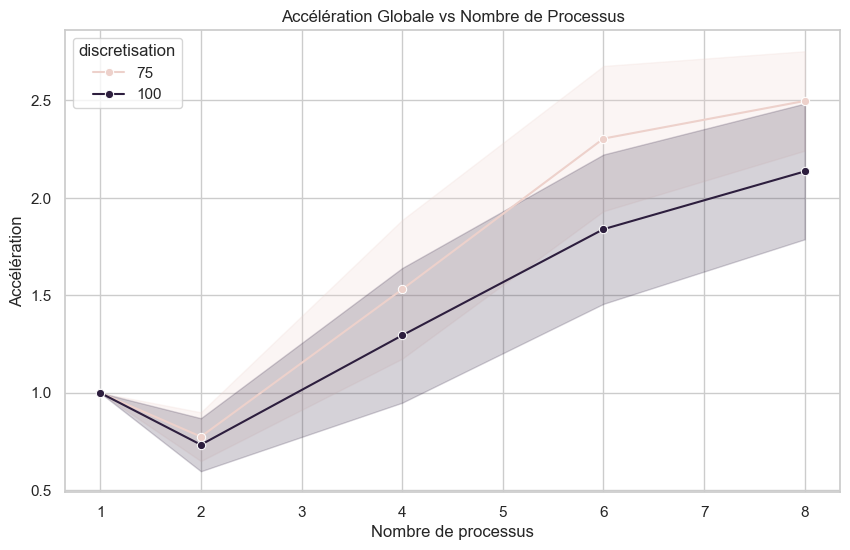

C:\Users\ibrah\AppData\Local\Temp\ipykernel_21112\6328147.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=data, x=x, y=y, hue=hue, marker='o', ci='sd')


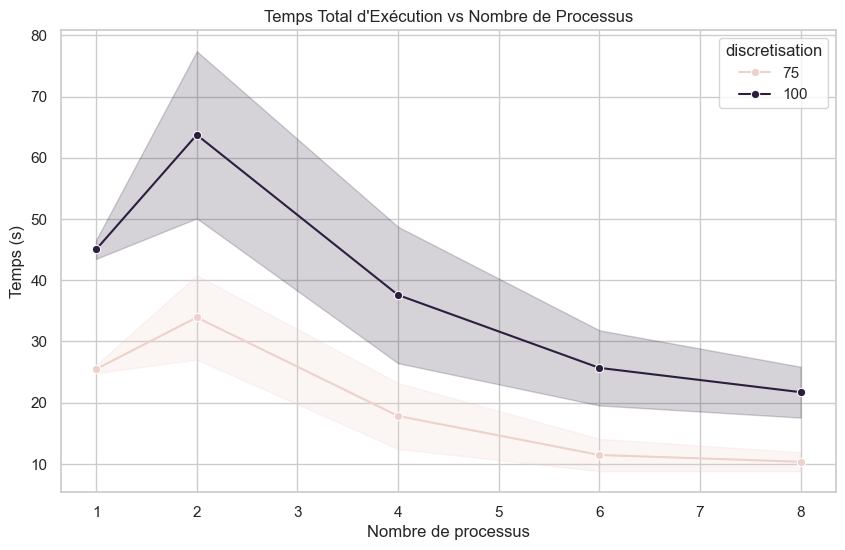

C:\Users\ibrah\AppData\Local\Temp\ipykernel_21112\6328147.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=data, x=x, y=y, hue=hue, marker='o', ci='sd')


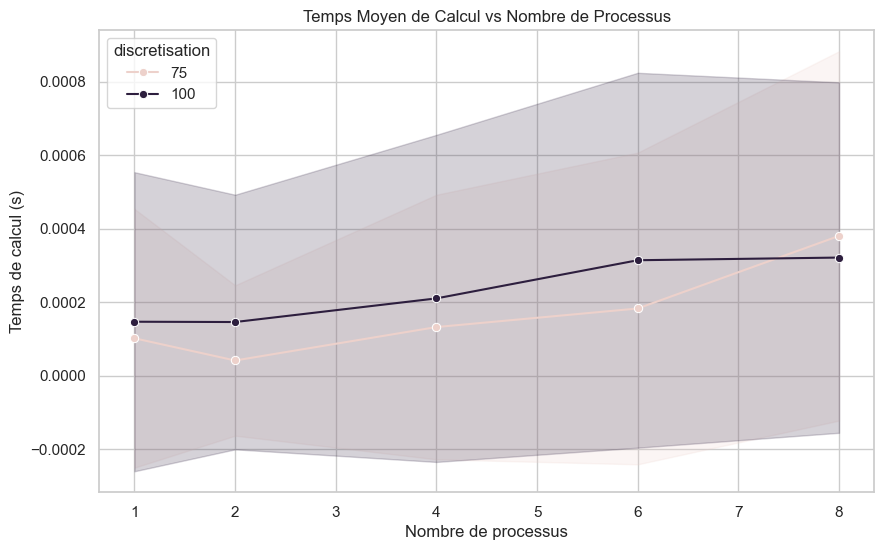

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Nettoyage : conversion des colonnes nécessaires
df['temps_calcul'] = pd.to_numeric(df['temps_calcul'], errors='coerce')
df['temps_iteration'] = pd.to_numeric(df['temps_iteration'], errors='coerce')

# Conversion des colonnes vent et start en tuples
df['vent'] = df['vent'].apply(lambda x: tuple(map(int, x.strip("()").split(","))))
df['start'] = df['start'].apply(lambda x: tuple(map(int, x.strip("()").split(","))))

# Calcul des accélérations
group_keys = ['longueur', 'discretisation', 'vent', 'start']
grouped = df.groupby(group_keys)

# Initialisation des colonnes d'accélération
df['accel_global'] = 0.0
df['accel_temp'] = 0.0

for keys, group in grouped:
    # Récupérer le temps de référence (1 processus)
    ref = group[group['nombre_de_processus'] == 1]
    if ref.empty:
        continue  # Ignorer les groupes sans référence
    
    t_ref_total = ref['temps_iteration'].values[0]
    t_ref_calc = ref['temps_calcul'].values[0]
    
    # Masque pour identifier le groupe courant
    mask = (
        (df['longueur'] == keys[0]) &
        (df['discretisation'] == keys[1]) &
        (df['vent'] == keys[2]) &
        (df['start'] == keys[3])
    )
    
    # Calcul de l'accélération globale (basée sur temps_iteration)
    df.loc[mask, 'accel_global'] = t_ref_total / df.loc[mask, 'temps_iteration']
    
    # Calcul de l'accélération temporelle (basée sur temps_calcul)
    df.loc[mask, 'accel_temp'] = df.loc[mask].apply(
        lambda row: t_ref_calc / row['temps_calcul'] if row['temps_calcul'] != 0 else 0,
        axis=1
    )

# Génération des graphes
sns.set(style="whitegrid")

def plot_graph(data, x, y, title, ylabel, filename, hue='discretisation'):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=y, hue=hue, marker='o', ci='sd')
    plt.title(title)
    plt.xlabel("Nombre de processus")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Filtrer les données pour éviter les doublons
df_plot = df.drop_duplicates(subset=['longueur', 'discretisation', 'vent', 'start', 'nombre_de_processus'])

# Accélération globale
plot_graph(
    df_plot,
    x="nombre_de_processus",
    y="accel_global",
    title="Accélération Globale vs Nombre de Processus",
    ylabel="Accélération",
    filename="accel_global.png"
)

# Temps total d'exécution
plot_graph(
    df_plot,
    x="nombre_de_processus",
    y="temps_iteration",
    title="Temps Total d'Exécution vs Nombre de Processus",
    ylabel="Temps (s)",
    filename="temps_total.png"
)

# Temps moyen de calcul
plot_graph(
    df_plot,
    x="nombre_de_processus",
    y="temps_calcul",
    title="Temps Moyen de Calcul vs Nombre de Processus",
    ylabel="Temps de calcul (s)",
    filename="temps_calcul.png"
)